In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pdb

from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt
from pprint import pprint

import polyphase as phase

In [3]:
dimensions = 3

config_list = [{'M':np.array([64,1,1]), 'chi': [1.0,0.3,0.2] },
               {'M':np.array([5,5,1]), 'chi': [1.0,0.5,0.5]}, 
              {'M':np.array([20,20,1]), 'chi': [1.0,0.5,0.5]}, 
               {'M':np.array([946,12,1]), 'chi': [0.43,0.45,0.60]}, # penn state example
               {'M':np.array([20,7,1]), 'chi': [1.0,0.4,0.9]}, # Balaji Phafic bug
               {'M':np.array([1,1,1]), 'chi': [2.31,2.31,2.31]} # Softmatter paper
              ]
   
configuration = config_list[0]
dop_str = 'M:' + ','.join('{}'.format(m) for m in configuration['M'])
chi_str = r'$\chi$: ' + ','.join('{:.2f}'.format(c) for c in configuration['chi'])
config_str = dop_str+'\n'+chi_str

dx = 100
pprint(config_str)
kwargs = {'flag_lift_label': True, 'use_weighted_delaunay': False,\
          'flag_remove_collinear' : False, 'beta':1e-4, \
          'flag_make_energy_paraboloid': True, 'flag_lift_purecomp_energy': False, \
         'thresh':1}
pprint(kwargs)
out = phase.compute(3, configuration, dx,  **kwargs)
grid = out['grid']
num_comps = out['num_comps']
simplices = out['simplices']
output = out['output']

'M:64,1,1\n$\\chi$: 1.00,0.30,0.20'
{'beta': 0.0001,
 'flag_lift_label': True,
 'flag_lift_purecomp_energy': False,
 'flag_make_energy_paraboloid': True,
 'flag_remove_collinear': False,
 'thresh': 1,
 'use_weighted_delaunay': False}


RayConnectionError: Ray has not been started yet. You can start Ray with 'ray.init()'.

In [ ]:
ax, cbar = phase.plot_mpltern(grid, simplices, num_comps)
plt.show()
# fname = '../figures/06-23-2020-Verify/'+'params_{}'.format(i) + '.png'
# plt.savefig(fname,dpi=500, bbox_inches='tight')
# plt.show()

In [4]:
import glob
images_dir = '../figures/hteplots/*.png'

images_list = sorted([file for file in glob.glob(images_dir)])

print('Total of {} phase diagrams'.format(len(images_list)))


Total of 456 phase diagrams


In [5]:
import torch
from PIL import Image
import torchvision.transforms as transforms

def img2tensor(image_file):
    pil_image = Image.open(image_file)
    p = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
    rgb_image_tensor = p(pil_image)[:3,:,:]
    
    return rgb_image_tensor

def imshow_tensor(rgb_image_tensor):
    plt.imshow(rgb_image_tensor.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

0 DPP(PhTT)2 MDMO-PPV


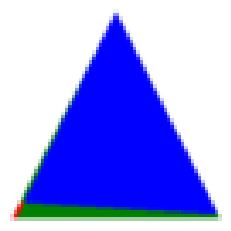

In [6]:
# Convert to a pytorch tensor
# Based on : https://www.cs.virginia.edu/~vicente/recognition/notebooks/image_processing_lab.html

import re
tags = re.compile('../figures/hteplots/(.*)_(.*)_(.*).png')

image_file = images_list[0]
polymer, sm, solvent = tags.findall(image_file)[0]
print(polymer, sm, solvent)
rgb_image_tensor = img2tensor(image_file)
imshow_tensor(rgb_image_tensor)

In [7]:
from numpy.linalg import norm

def distance_image(candidate, query):
    img1 = img2tensor(candidate[0])
    img2 = img2tensor(query[0])
    diff = img1 - img2
    dist = norm(diff)
    
    return dist

In [15]:
from scipy.spatial.distance import pdist, squareform, euclidean
import ray
import time
from collections import Counter

@ray.remote
def get_distance_row(data, metric, rowid, triuids):
    
    rowid_flags = triuids[0]
    rows = triuids[0][rowid_flags==rowid]
    cols = triuids[1][rowid_flags==rowid]
    dist_row = []
    for r,c in zip(rows, cols):
        dist_row.append(metric(data[r,:], data[c,:]))
                        
    return dist_row

def get_distance_matrix(X, metric):
    ray.init(ignore_reinit_error=True)
    print('Following nodes are connected: ')
    print(ray.services.get_node_ip_address())
    
    start = time.time()
    n_samples, n_features = X.shape
    nC2 = 0.5*(n_samples*(n_samples-1))
    iu = np.triu_indices(n_samples,1)
    iu_ray = ray.put(iu)
    row_ids = np.unique(iu[0])
    
    dist_ray = [get_distance_row.remote(X, metric, rowid, iu_ray) for rowid in row_ids]
    dist = np.hstack(ray.get(dist_ray))
    
    assert nC2==len(dist), "Not all the reduced distances are returned"
    
    D = squareform(dist)
    
    assert n_samples==np.shape(D)[0] , "Shape of distance matrix is not {}x{}".format(n_samples)
    
    del dist_ray, iu_ray 
    
    end = time.time()
    print('Computation took : {:.2f} sec'.format(end-start))
    
    ray.shutdown()
    
    return D  

In [16]:
X = np.asarray(images_list[:50]).reshape(-1,1)
M = get_distance_matrix(X, distance_image) 
print(M.shape)

2020-08-12 15:50:06,767	INFO resource_spec.py:212 -- Starting Ray with 26.66 GiB memory available for workers and up to 13.35 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-08-12 15:50:07,034	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-12 15:50:07,246	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


Following nodes are connected: 
10.111.8.2
Computation took : 45.44 sec
(50, 50)


In [ ]:
from scipy.spatial.distance import pdist, squareform

X = np.asarray(images_list).reshape(-1,1)
D = pdist(X, distance_image)
M = squareform(D)
print(M.shape)

In [17]:
import re
tagger = re.compile('../figures/hteplots/(.*)_(.*)_(.*).png')

tags_list = []
for img in images_list:
    tag = tagger.findall(img)
    tags_list.append(tag[0])
    
tags_array = np.asarray(tags_list)
print(tags_array.shape)

(456, 3)


In [18]:
from sklearn.manifold import TSNE
X_emb = TSNE(n_components=2, metric='precomputed').fit_transform(M)

In [22]:
import seaborn as sns

sns.scatterplot(x=X_emb[:,0],y= X_emb[:,1], hue = tags_array[:50,0], palette="Set2")
plt.savefig('../figures/notebooks/tsne_hte_solvent.png', dpi=400)
sns.scatterplot(x=X_emb[:,0],y= X_emb[:,1], hue = tags_array[:50,1], palette="Set2")
plt.savefig('../figures/notebooks/tsne_hte_smallmolecule.png', dpi=400)
sns.scatterplot(x=X_emb[:,0],y= X_emb[:,1], hue = tags_array[:50,2], palette="Set2")
plt.savefig('../figures/notebooks/tsne_hte_polymer.png', dpi=400)
plt.close('all')